In [8]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *
%aimport multi_segment_regressor
from multi_segment_regressor import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [10]:
import logging
set_logger(logging.INFO)

In [6]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid', 'property_address_school_transactions']


In [7]:
#df_transaction = ds.get_view_df('property_address_school_transactions')
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1475109, 25)
(709325, 22)


In [73]:
pp = Preprocess(df_transaction, df_property)
use_features = pp.get_feature_list()

In [74]:
use_features = ['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat',
 #'min_elem_distance',
 #'min_middle_distance',
 #'min_high_distance',
 #'elem_rating',
 #'middle_rating',
 #'high_rating',
 #'avg_elem_rating',
 #'avg_middle_rating',
 #'avg_high_rating',
 ]

In [75]:
# records of last year
df_track = pp.dataset(feature='all', valid=True, clean=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] transforming eval
[dp] transforming eval_sqft_price
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip


(67218, 26)

In [17]:
df_track.head()

,sqft_price_zip_avg,sold_age,zip,street,num_bath,eval_imps,sold_price,id,eval,lat,...,impr_over_land,sqft_zip_avg,view,sold_price_zip_avg,pool,sqft_price,sale_count_zip,date,eval_land,num_bed
1,264.264499,30.000000,92020,CHAMBERS,1.0,89817,158500,1392761,161669,32.79673,...,1.250028,1678.766257,0,429138.400703,0,216,1138,2015-10-01,71852,1.0
61301,391.174863,38.000000,92122,CAMINITO ARAYA,1.0,92675,318000,1392788,324359,32.85025,...,0.400006,1347.417122,0,516158.925319,0,347,1098,2015-10-01,231684,1.0
9718,324.592027,112.000000,92127,FIELDTHORN,2.0,249900,595000,1392721,606900,33.01318,...,0.700000,2648.682358,0,858583.757422,0,421,2358,2015-10-01,357000,3.0
9719,324.592027,26.731502,92127,HUNTERS RIDGE,2.0,421086,848000,1392758,864959,33.03887,...,0.948663,2648.682358,0,858583.757422,0,308,2358,2015-10-01,443873,4.0
60075,251.726754,26.731502,91915,KENSINGTON,3.0,248698,415000,1392786,423299,32.61862,...,1.424379,1895.782219,0,462969.412724,0,240,1226,2015-10-01,174601,3.0


In [85]:
import time
from itertools import cycle, islice

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

def clustering(cluster_features, iteration):
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(df_track[cluster_features])
    plt.figure(figsize=(9 * 2 + 3, 3*iteration+.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    measure = {'MiniBatchKMeans':[],
               'BayesianGaussianMixture':[]
              }
    plot_num = 1
    for n in range(3,3+iteration):
        two_means = cluster.MiniBatchKMeans(n_clusters=n)
        #ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        spectral = cluster.SpectralClustering(n_clusters=n, eigen_solver='arpack', affinity="nearest_neighbors")
        #dbscan = cluster.DBSCAN(eps=.3)
        #affinity_propagation = cluster.AffinityPropagation(damping=.9, preference=-200)
        gmm = mixture.GaussianMixture(n_components=n, covariance_type='full')
        bgm = mixture.BayesianGaussianMixture(n_components=n, covariance_type='full')

        clustering_algorithms = [
                ('MiniBatchKMeans', two_means),
        #        ('AffinityPropagation', affinity_propagation),
        #        ('MeanShift', ms),
        #        ('SpectralClustering', spectral),
        #        ('Ward', ward),
        #        ('AgglomerativeClustering', average_linkage),
        #        ('DBSCAN', dbscan),
        #        ('Birch', birch),
        #        ('GaussianMixture', gmm),
        #        ('BayesianGaussianMixture', bgm)
        ]

        for clustering in clustering_algorithms:
            name, algorithm = clustering[0], clustering[1]
            t0 = time.time()
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            if name == 'BayesianGaussianMixture':
                measure[name].append(algorithm.lower_bound_)
            else:
                measure[name].append(algorithm.inertia_)

            plt.subplot(iteration, 2, plot_num)
            plt.title("{} {} clusters on {}".format(name, n, cluster_features), size=18)

            colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                                     '#f781bf', '#a65628', '#984ea3',
                                                     '#999999', '#e41a1c', '#dede00']),
                                              int(max(y_pred) + 1))))
            #plt.scatter(df_track['lon'], df_track['lat'], s=10, color=colors[y_pred], alpha=0.2)
            plt.scatter(df_track['sold_price'], y_pred, s=10, color=colors[y_pred], alpha=0.2)
            plt.xticks(())
            plt.yticks(())
            plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
            plot_num += 1
    plt.show()
    return measure

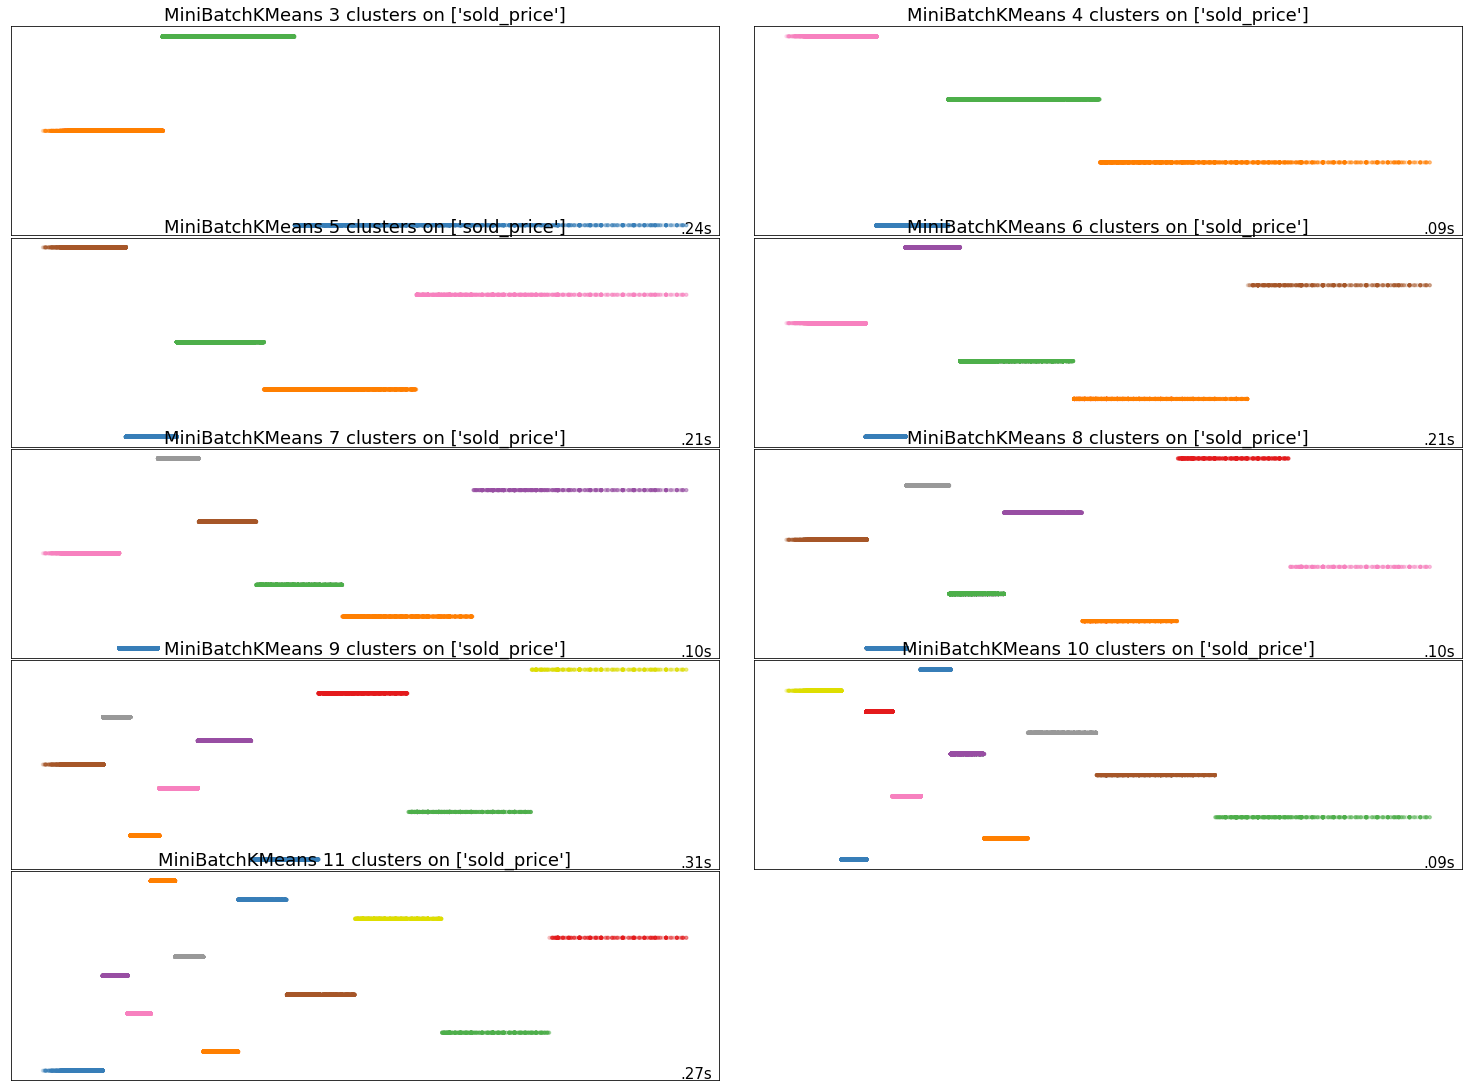

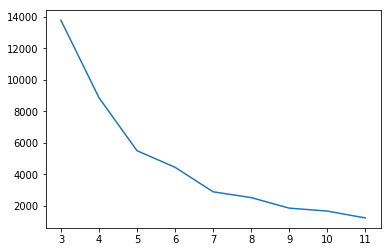

In [86]:
measure = clustering(['sold_price'], 9)
plt.figure()
plt.title
plt.plot(list(range(3,3+9)), measure['MiniBatchKMeans'])
plt.show()

### baseline model

In [59]:

rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
print(df_track.shape)
monthly_volume = int(df_track.shape[0] / 24)
mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 56018, 33600, 11200


(67218, 25)


112639.94031544629

In [22]:
### assume the we can do same clustering on test dataset
def remeasure(df_checks):
    df_merged = pd.concat(df_checks)
    return sqrt(mean_squared_error(df_merged['predict'], df_merged['sold_price']))

def measure_segments(cluster_features, cluster_range):
    errors = []
    for n in cluster_range:
        X = StandardScaler().fit_transform(df_track[cluster_features])
        clustering = cluster.MiniBatchKMeans(n_clusters=n)
        #clustering = mixture.BayesianGaussianMixture(n_components=n, covariance_type='full')
        clustering.fit(X)
        y_pred = clustering.predict(X)

        results = []
        for i in range(n):
            df_subset = df_track[y_pred==i]
            rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
            print(df_subset.shape)
            monthly_volume = int(df_subset.shape[0] / 24)
            mm = ModelManager(df_subset, use_features, rf, time_series=True)
            mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)
            results.append(mm.get_result_df())
        errors.append(remeasure(results))
    return errors

[dp] track/sliding/test window size: 18585, 11148, 3716
[dp] train/valid/test size: 14868, 3717, 3716
[dp] validation step is skipped


(22301, 14)


[dp] track/sliding/test window size: 16582, 9948, 3316
[dp] train/valid/test size: 13265, 3317, 3316
[dp] validation step is skipped


(19898, 14)


[dp] track/sliding/test window size: 20853, 12504, 4168
[dp] train/valid/test size: 16682, 4171, 4168
[dp] validation step is skipped


(25021, 14)


[dp] track/sliding/test window size: 18515, 11100, 3700
[dp] train/valid/test size: 14812, 3703, 3700
[dp] validation step is skipped


(22215, 14)


[dp] track/sliding/test window size: 13103, 7848, 2616
[dp] train/valid/test size: 10482, 2621, 2616
[dp] validation step is skipped


(15719, 14)


[dp] track/sliding/test window size: 14762, 8856, 2952
[dp] train/valid/test size: 11809, 2953, 2952
[dp] validation step is skipped


(17714, 14)


[dp] track/sliding/test window size: 9644, 5784, 1928
[dp] train/valid/test size: 7715, 1929, 1928
[dp] validation step is skipped


(11572, 14)


[dp] track/sliding/test window size: 10307, 6180, 2060
[dp] train/valid/test size: 8245, 2062, 2060
[dp] validation step is skipped


(12367, 14)


[dp] track/sliding/test window size: 18812, 11280, 3760
[dp] train/valid/test size: 15049, 3763, 3760
[dp] validation step is skipped


(22572, 14)


[dp] track/sliding/test window size: 497, 288, 96
[dp] train/valid/test size: 397, 100, 96
[dp] validation step is skipped


(593, 14)


[dp] track/sliding/test window size: 13150, 7884, 2628
[dp] train/valid/test size: 10520, 2630, 2628
[dp] validation step is skipped


(15778, 14)


[dp] track/sliding/test window size: 13262, 7944, 2648
[dp] train/valid/test size: 10609, 2653, 2648
[dp] validation step is skipped


(15910, 14)


[dp] track/sliding/test window size: 10992, 6588, 2196
[dp] train/valid/test size: 8793, 2199, 2196
[dp] validation step is skipped


(13188, 14)


[dp] track/sliding/test window size: 9045, 5424, 1808
[dp] train/valid/test size: 7236, 1809, 1808
[dp] validation step is skipped


(10853, 14)


[dp] track/sliding/test window size: 12596, 7548, 2516
[dp] train/valid/test size: 10076, 2520, 2516
[dp] validation step is skipped


(15112, 14)


[dp] track/sliding/test window size: 9522, 5712, 1904
[dp] train/valid/test size: 7617, 1905, 1904
[dp] validation step is skipped


(11426, 14)


[dp] track/sliding/test window size: 5386, 3228, 1076
[dp] train/valid/test size: 4308, 1078, 1076
[dp] validation step is skipped


(6462, 14)


[dp] track/sliding/test window size: 8483, 5088, 1696
[dp] train/valid/test size: 6786, 1697, 1696
[dp] validation step is skipped


(10179, 14)


[dp] track/sliding/test window size: 9612, 5760, 1920
[dp] train/valid/test size: 7689, 1923, 1920
[dp] validation step is skipped


(11532, 14)


[dp] track/sliding/test window size: 13209, 7920, 2640
[dp] train/valid/test size: 10567, 2642, 2640
[dp] validation step is skipped


(15849, 14)


[dp] track/sliding/test window size: 6321, 3780, 1260
[dp] train/valid/test size: 5056, 1265, 1260
[dp] validation step is skipped


(7581, 14)


[dp] track/sliding/test window size: 8623, 5172, 1724
[dp] train/valid/test size: 6898, 1725, 1724
[dp] validation step is skipped


(10347, 14)


[dp] track/sliding/test window size: 6300, 3768, 1256
[dp] train/valid/test size: 5040, 1260, 1256
[dp] validation step is skipped


(7556, 14)


[dp] track/sliding/test window size: 494, 288, 96
[dp] train/valid/test size: 395, 99, 96
[dp] validation step is skipped


(590, 14)


[dp] track/sliding/test window size: 11473, 6876, 2292
[dp] train/valid/test size: 9178, 2295, 2292
[dp] validation step is skipped


(13765, 14)


[dp] track/sliding/test window size: 12031, 7212, 2404
[dp] train/valid/test size: 9624, 2407, 2404
[dp] validation step is skipped


(14435, 14)


[dp] track/sliding/test window size: 9067, 5436, 1812
[dp] train/valid/test size: 7253, 1814, 1812
[dp] validation step is skipped


(10879, 14)


[dp] track/sliding/test window size: 9109, 5460, 1820
[dp] train/valid/test size: 7287, 1822, 1820
[dp] validation step is skipped


(10929, 14)


[dp] track/sliding/test window size: 6971, 4176, 1392
[dp] train/valid/test size: 5576, 1395, 1392
[dp] validation step is skipped


(8363, 14)


[dp] track/sliding/test window size: 7477, 4476, 1492
[dp] train/valid/test size: 5981, 1496, 1492
[dp] validation step is skipped


(8969, 14)


[dp] track/sliding/test window size: 492, 288, 96
[dp] train/valid/test size: 393, 99, 96
[dp] validation step is skipped


(588, 14)


[dp] track/sliding/test window size: 6760, 4056, 1352
[dp] train/valid/test size: 5408, 1352, 1352
[dp] validation step is skipped


(8112, 14)


[dp] track/sliding/test window size: 4121, 2472, 824
[dp] train/valid/test size: 3296, 825, 824
[dp] validation step is skipped


(4945, 14)


[dp] track/sliding/test window size: 7143, 4272, 1424
[dp] train/valid/test size: 5714, 1429, 1424
[dp] validation step is skipped


(8567, 14)


[dp] track/sliding/test window size: 5531, 3312, 1104
[dp] train/valid/test size: 4424, 1107, 1104
[dp] validation step is skipped


(6635, 14)


[dp] track/sliding/test window size: 8503, 5088, 1696
[dp] train/valid/test size: 6802, 1701, 1696
[dp] validation step is skipped


(10199, 14)


[dp] track/sliding/test window size: 9978, 5976, 1992
[dp] train/valid/test size: 7982, 1996, 1992
[dp] validation step is skipped


(11970, 14)


[dp] track/sliding/test window size: 8151, 4884, 1628
[dp] train/valid/test size: 6520, 1631, 1628
[dp] validation step is skipped


(9779, 14)


[dp] track/sliding/test window size: 5263, 3144, 1048
[dp] train/valid/test size: 4210, 1053, 1048
[dp] validation step is skipped


(6311, 14)


[dp] track/sliding/test window size: 4029, 2412, 804
[dp] train/valid/test size: 3223, 806, 804
[dp] validation step is skipped


(4833, 14)


[dp] track/sliding/test window size: 492, 288, 96
[dp] train/valid/test size: 393, 99, 96
[dp] validation step is skipped


(588, 14)


[dp] track/sliding/test window size: 6950, 4164, 1388
[dp] train/valid/test size: 5560, 1390, 1388
[dp] validation step is skipped


(8338, 14)


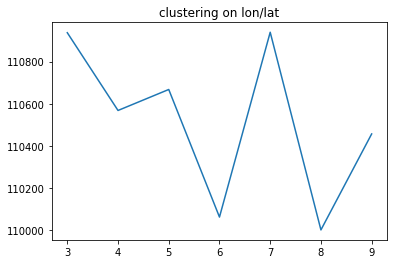

In [33]:
cluster_range = list(range(3,9))
errors = measure_segments(['lon', 'lat'], cluster_range)

plt.figure()
plt.title('clustering on lon/lat')
plt.plot(cluster_range, errors)
plt.show()

[dp] track/sliding/test window size: 19958, 11964, 3988
[dp] train/valid/test size: 15966, 3992, 3988
[dp] validation step is skipped


(23946, 14)


[dp] track/sliding/test window size: 5461, 3276, 1092
[dp] train/valid/test size: 4368, 1093, 1092
[dp] validation step is skipped


(6553, 14)


[dp] track/sliding/test window size: 30601, 18360, 6120
[dp] train/valid/test size: 24480, 6121, 6120
[dp] validation step is skipped


(36721, 14)


[dp] track/sliding/test window size: 13604, 8160, 2720
[dp] train/valid/test size: 10883, 2721, 2720
[dp] validation step is skipped


(16324, 14)


[dp] track/sliding/test window size: 11863, 7104, 2368
[dp] train/valid/test size: 9490, 2373, 2368
[dp] validation step is skipped


(14231, 14)


[dp] track/sliding/test window size: 5332, 3192, 1064
[dp] train/valid/test size: 4265, 1067, 1064
[dp] validation step is skipped


(6396, 14)


[dp] track/sliding/test window size: 25225, 15132, 5044
[dp] train/valid/test size: 20180, 5045, 5044
[dp] validation step is skipped


(30269, 14)


C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[dp] track/sliding/test window size: 2241, 1332, 444
[dp] train/valid/test size: 1792, 449, 444
[dp] validation step is skipped


(2685, 14)


[dp] track/sliding/test window size: 8733, 5232, 1744
[dp] train/valid/test size: 6986, 1747, 1744
[dp] validation step is skipped


(10477, 14)


[dp] track/sliding/test window size: 26060, 15624, 5208
[dp] train/valid/test size: 20848, 5212, 5208
[dp] validation step is skipped


(31268, 14)


[dp] track/sliding/test window size: 11733, 7032, 2344
[dp] train/valid/test size: 9386, 2347, 2344
[dp] validation step is skipped


(14077, 14)


[dp] track/sliding/test window size: 7261, 4356, 1452
[dp] train/valid/test size: 5808, 1453, 1452
[dp] validation step is skipped


(8713, 14)


[dp] track/sliding/test window size: 10195, 6108, 2036
[dp] train/valid/test size: 8156, 2039, 2036
[dp] validation step is skipped


(12231, 14)


[dp] track/sliding/test window size: 17546, 10524, 3508
[dp] train/valid/test size: 14036, 3510, 3508
[dp] validation step is skipped


(21054, 14)


[dp] track/sliding/test window size: 11593, 6948, 2316
[dp] train/valid/test size: 9274, 2319, 2316
[dp] validation step is skipped


(13909, 14)


[dp] track/sliding/test window size: 5657, 3384, 1128
[dp] train/valid/test size: 4525, 1132, 1128
[dp] validation step is skipped


(6785, 14)


[dp] track/sliding/test window size: 2181, 1308, 436
[dp] train/valid/test size: 1744, 437, 436
[dp] validation step is skipped


(2617, 14)


[dp] track/sliding/test window size: 8856, 5304, 1768
[dp] train/valid/test size: 7084, 1772, 1768
[dp] validation step is skipped


(10624, 14)


[dp] track/sliding/test window size: 1590, 948, 316
[dp] train/valid/test size: 1272, 318, 316
[dp] validation step is skipped


(1906, 14)


[dp] track/sliding/test window size: 2959, 1764, 588
[dp] train/valid/test size: 2367, 592, 588
[dp] validation step is skipped


(3547, 14)


[dp] track/sliding/test window size: 9228, 5532, 1844
[dp] train/valid/test size: 7382, 1846, 1844
[dp] validation step is skipped


(11072, 14)


[dp] track/sliding/test window size: 17417, 10440, 3480
[dp] train/valid/test size: 13933, 3484, 3480
[dp] validation step is skipped


(20897, 14)


[dp] track/sliding/test window size: 4483, 2676, 892
[dp] train/valid/test size: 3586, 897, 892
[dp] validation step is skipped


(5375, 14)


[dp] track/sliding/test window size: 8978, 5376, 1792
[dp] train/valid/test size: 7182, 1796, 1792
[dp] validation step is skipped


(10770, 14)


[dp] track/sliding/test window size: 11381, 6816, 2272
[dp] train/valid/test size: 9104, 2277, 2272
[dp] validation step is skipped


(13653, 14)


C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
[dp] track/sliding/test window size: 1557, 924, 308
[dp] train/valid/test size: 1245, 312, 308
[dp] validation step is skipped


(1865, 14)


[dp] track/sliding/test window size: 4443, 2652, 884
[dp] train/valid/test size: 3554, 889, 884
[dp] validation step is skipped


(5327, 14)


[dp] track/sliding/test window size: 7394, 4428, 1476
[dp] train/valid/test size: 5915, 1479, 1476
[dp] validation step is skipped


(8870, 14)


[dp] track/sliding/test window size: 17390, 10428, 3476
[dp] train/valid/test size: 13912, 3478, 3476
[dp] validation step is skipped


(20866, 14)


[dp] track/sliding/test window size: 4893, 2928, 976
[dp] train/valid/test size: 3914, 979, 976
[dp] validation step is skipped


(5869, 14)


[dp] track/sliding/test window size: 8932, 5352, 1784
[dp] train/valid/test size: 7145, 1787, 1784
[dp] validation step is skipped


(10716, 14)


[dp] track/sliding/test window size: 9567, 5736, 1912
[dp] train/valid/test size: 7653, 1914, 1912
[dp] validation step is skipped


(11479, 14)


[dp] track/sliding/test window size: 1860, 1104, 368
[dp] train/valid/test size: 1488, 372, 368
[dp] validation step is skipped


(2228, 14)


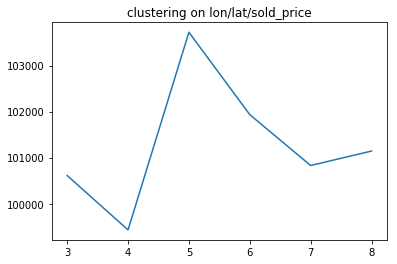

In [29]:
cluster_range = list(range(3,9))
errors = measure_segments(['lon', 'lat', 'eval'], cluster_range)

plt.figure()
plt.title('clustering on lon/lat/sold_price')
plt.plot(cluster_range, errors)
plt.show()

[dp] track/sliding/test window size: 38750, 23244, 7748
[dp] train/valid/test size: 31000, 7750, 7748
[dp] validation step is skipped


(46498, 25)


[dp] track/sliding/test window size: 2824, 1692, 564
[dp] train/valid/test size: 2259, 565, 564
[dp] validation step is skipped


(3388, 25)


[dp] track/sliding/test window size: 14446, 8664, 2888
[dp] train/valid/test size: 11556, 2890, 2888
[dp] validation step is skipped


(17334, 25)


[dp] track/sliding/test window size: 7692, 4608, 1536
[dp] train/valid/test size: 6153, 1539, 1536
[dp] validation step is skipped


(9228, 25)


[dp] track/sliding/test window size: 25369, 15216, 5072
[dp] train/valid/test size: 20295, 5074, 5072
[dp] validation step is skipped


(30441, 25)


[dp] track/sliding/test window size: 2055, 1224, 408
[dp] train/valid/test size: 1644, 411, 408
[dp] validation step is skipped


(2463, 25)


[dp] track/sliding/test window size: 20908, 12540, 4180
[dp] train/valid/test size: 16726, 4182, 4180
[dp] validation step is skipped


(25088, 25)


[dp] track/sliding/test window size: 7501, 4500, 1500
[dp] train/valid/test size: 6000, 1501, 1500
[dp] validation step is skipped


(9001, 25)


[dp] track/sliding/test window size: 19383, 11628, 3876
[dp] train/valid/test size: 15506, 3877, 3876
[dp] validation step is skipped


(23259, 25)


[dp] track/sliding/test window size: 2196, 1308, 436
[dp] train/valid/test size: 1756, 440, 436
[dp] validation step is skipped


(2632, 25)


[dp] track/sliding/test window size: 16460, 9864, 3288
[dp] train/valid/test size: 13168, 3292, 3288
[dp] validation step is skipped


(19748, 25)


[dp] track/sliding/test window size: 10484, 6288, 2096
[dp] train/valid/test size: 8387, 2097, 2096
[dp] validation step is skipped


(12580, 25)


[dp] track/sliding/test window size: 19906, 11940, 3980
[dp] train/valid/test size: 15924, 3982, 3980
[dp] validation step is skipped


(23886, 25)


[dp] track/sliding/test window size: 1076, 636, 212
[dp] train/valid/test size: 860, 216, 212
[dp] validation step is skipped


(1288, 25)


[dp] track/sliding/test window size: 6721, 4020, 1340
[dp] train/valid/test size: 5376, 1345, 1340
[dp] validation step is skipped


(8061, 25)


[dp] track/sliding/test window size: 14660, 8796, 2932
[dp] train/valid/test size: 11728, 2932, 2932
[dp] validation step is skipped


(17592, 25)


[dp] track/sliding/test window size: 10940, 6564, 2188
[dp] train/valid/test size: 8752, 2188, 2188
[dp] validation step is skipped


(13128, 25)


[dp] track/sliding/test window size: 2721, 1632, 544
[dp] train/valid/test size: 2176, 545, 544
[dp] validation step is skipped


(3265, 25)


[dp] track/sliding/test window size: 17348, 10404, 3468
[dp] train/valid/test size: 13878, 3470, 3468
[dp] validation step is skipped


(20816, 25)


[dp] track/sliding/test window size: 1923, 1140, 380
[dp] train/valid/test size: 1538, 385, 380
[dp] validation step is skipped


(2303, 25)


[dp] track/sliding/test window size: 3881, 2328, 776
[dp] train/valid/test size: 3104, 777, 776
[dp] validation step is skipped


(4657, 25)


[dp] track/sliding/test window size: 643, 372, 124
[dp] train/valid/test size: 514, 129, 124
[dp] validation step is skipped


(767, 25)


[dp] track/sliding/test window size: 8355, 5004, 1668
[dp] train/valid/test size: 6684, 1671, 1668
[dp] validation step is skipped


(10023, 25)


[dp] track/sliding/test window size: 13543, 8124, 2708
[dp] train/valid/test size: 10834, 2709, 2708
[dp] validation step is skipped


(16251, 25)


[dp] track/sliding/test window size: 10339, 6192, 2064
[dp] train/valid/test size: 8271, 2068, 2064
[dp] validation step is skipped


(12403, 25)


[dp] track/sliding/test window size: 12127, 7272, 2424
[dp] train/valid/test size: 9701, 2426, 2424
[dp] validation step is skipped


(14551, 25)


[dp] track/sliding/test window size: 5684, 3408, 1136
[dp] train/valid/test size: 4547, 1137, 1136
[dp] validation step is skipped


(6820, 25)


[dp] track/sliding/test window size: 1062, 624, 208
[dp] train/valid/test size: 849, 213, 208
[dp] validation step is skipped


(1270, 25)


[dp] track/sliding/test window size: 21820, 13080, 4360
[dp] train/valid/test size: 17456, 4364, 4360
[dp] validation step is skipped


(26180, 25)


[dp] track/sliding/test window size: 498, 288, 96
[dp] train/valid/test size: 398, 100, 96
[dp] validation step is skipped


(594, 25)


[dp] track/sliding/test window size: 12525, 7512, 2504
[dp] train/valid/test size: 10020, 2505, 2504
[dp] validation step is skipped


(15029, 25)


[dp] track/sliding/test window size: 2138, 1272, 424
[dp] train/valid/test size: 1710, 428, 424
[dp] validation step is skipped


(2562, 25)


[dp] track/sliding/test window size: 182, 96, 32
[dp] train/valid/test size: 145, 37, 32
[dp] validation step is skipped


(214, 25)


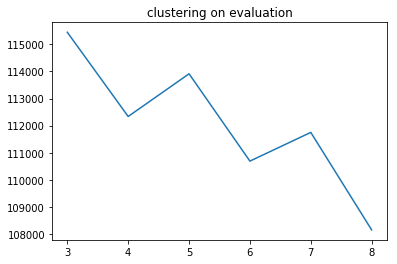

In [23]:
cluster_range = list(range(3,9))
errors = measure_segments(['eval'], cluster_range)

plt.figure()
plt.title('clustering on evaluation')
plt.plot(cluster_range, errors)
plt.show()

[dp] track/sliding/test window size: 29513, 17700, 5900
[dp] validation step is skipped


(35413, 25)


[dp] track/sliding/test window size: 3659, 2184, 728
[dp] validation step is skipped


(4387, 25)


[dp] track/sliding/test window size: 22852, 13704, 4568
[dp] validation step is skipped


(27420, 25)


[dp] track/sliding/test window size: 21302, 12768, 4256
[dp] validation step is skipped


(25558, 25)


[dp] track/sliding/test window size: 8031, 4812, 1604
[dp] validation step is skipped


(9635, 25)


[dp] track/sliding/test window size: 1921, 1140, 380
[dp] validation step is skipped


(2301, 25)


[dp] track/sliding/test window size: 24774, 14856, 4952
[dp] validation step is skipped


(29726, 25)


[dp] track/sliding/test window size: 21523, 12912, 4304
[dp] validation step is skipped


(25827, 25)


[dp] track/sliding/test window size: 946, 564, 188
[dp] validation step is skipped


(1134, 25)


[dp] track/sliding/test window size: 2949, 1764, 588
[dp] validation step is skipped


(3537, 25)


[dp] track/sliding/test window size: 22039, 13212, 4404
[dp] validation step is skipped


(26443, 25)


[dp] track/sliding/test window size: 8567, 5136, 1712
[dp] validation step is skipped


(10279, 25)


[dp] track/sliding/test window size: 14208, 8520, 2840
[dp] validation step is skipped


(17048, 25)


[dp] track/sliding/test window size: 3187, 1908, 636
[dp] validation step is skipped


(3823, 25)


[dp] track/sliding/test window size: 11833, 7092, 2364
[dp] validation step is skipped


(14197, 25)


[dp] track/sliding/test window size: 1062, 636, 212
[dp] validation step is skipped


(1274, 25)


[dp] track/sliding/test window size: 7622, 4572, 1524
[dp] validation step is skipped


(9146, 25)


[dp] track/sliding/test window size: 18112, 10860, 3620
[dp] validation step is skipped


(21732, 25)


[dp] track/sliding/test window size: 21273, 12756, 4252
[dp] validation step is skipped


(25525, 25)


[dp] track/sliding/test window size: 995, 588, 196
[dp] validation step is skipped


(1191, 25)


[dp] track/sliding/test window size: 4928, 2952, 984
[dp] validation step is skipped


(5912, 25)


[dp] track/sliding/test window size: 15394, 9228, 3076
[dp] validation step is skipped


(18470, 25)


[dp] track/sliding/test window size: 2389, 1428, 476
[dp] validation step is skipped


(2865, 25)


[dp] track/sliding/test window size: 561, 324, 108
[dp] validation step is skipped


(669, 25)


[dp] track/sliding/test window size: 10492, 6288, 2096
[dp] validation step is skipped


(12588, 25)


[dp] track/sliding/test window size: 17422, 10440, 3480
[dp] validation step is skipped


(20902, 25)


[dp] track/sliding/test window size: 4108, 2460, 820
[dp] validation step is skipped


(4928, 25)


[dp] track/sliding/test window size: 763, 456, 152
[dp] validation step is skipped


(915, 25)


[dp] track/sliding/test window size: 11052, 6624, 2208
[dp] validation step is skipped


(13260, 25)


[dp] track/sliding/test window size: 6683, 4008, 1336
[dp] validation step is skipped


(8019, 25)


[dp] track/sliding/test window size: 300, 168, 56
[dp] validation step is skipped


(356, 25)


[dp] track/sliding/test window size: 14090, 8448, 2816
[dp] validation step is skipped


(16906, 25)


[dp] track/sliding/test window size: 1614, 960, 320
[dp] validation step is skipped


(1934, 25)


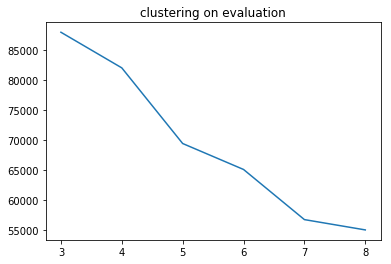

In [26]:
cluster_range = list(range(3,9))
errors = measure_segments(['sold_price'], cluster_range)

plt.figure()
plt.title('clustering on sold price')
plt.plot(cluster_range, errors)
plt.show()

### clustering on target 'sold_price'
* assume we can know the cluster the test dataset belongs to with some voting method

In [70]:
monthly_volume = int(df_track.shape[0] / 24)
test_size=monthly_volume*4
sliding_window=monthly_volume*12

features = use_features+['sold_price']
feature_set = list(use_features)
feature_set.remove('date')
rf = MultiSegmentRegressor(n_clusters=3, feature_set=feature_set, cluster_features=['sold_price'], cluster_on_target=True)
mm = ModelManager(df_track, features, rf, time_series=True)
mm.run(sliding_window=sliding_window, test_size=test_size)

[dp] track/sliding/test window size: 56018, 33600, 11200


344609.83818620554

In [30]:
r = mm.model.inspect()
r[:10]

,predict0,predict1,predict2,cluster0,cluster1,cluster2
0,505431.030670,1.385228e+06,1.018302e+06,0,1,2
1,501687.921834,1.286239e+06,6.485093e+05,0,1,2
2,518322.012936,1.225164e+06,6.459634e+05,0,1,2
3,408448.033276,1.268059e+06,6.243877e+05,0,1,2
4,436018.194143,1.242221e+06,6.068527e+05,0,1,2
5,530666.730916,1.418005e+06,6.528779e+05,0,1,2
6,531669.869534,1.261369e+06,6.050299e+05,0,1,2
7,453667.676141,1.275055e+06,6.037123e+05,0,1,2
8,433098.169985,1.260803e+06,6.073127e+05,0,1,2
9,189715.571829,1.246027e+06,6.069767e+05,0,1,2


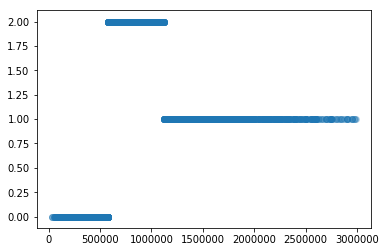

In [28]:
plt.figure()
plt.scatter(mm.model.X['sold_price'], mm.model.y_train_cluster, alpha=0.2)
plt.show()

In [78]:
import copy
### cluster on eval
monthly_volume = int(df_track.shape[0] / 24)
test_size=monthly_volume*4
sliding_window=monthly_volume*12

features = use_features+['eval']
feature_set = list(use_features)
feature_set.remove('date')

errors = []
for n in range(3,9):
    rf = MultiSegmentRegressor(n_clusters=3, feature_set=feature_set, cluster_features=['eval'])
    mm = ModelManager(df_track, features, rf, time_series=True)
    error = mm.run(sliding_window=sliding_window, test_size=test_size)
    errors.append(error)

[dp] track/sliding/test window size: 56018, 33600, 11200
[dp] track/sliding/test window size: 56018, 33600, 11200
[dp] track/sliding/test window size: 56018, 33600, 11200
[dp] track/sliding/test window size: 56018, 33600, 11200
[dp] track/sliding/test window size: 56018, 33600, 11200
[dp] track/sliding/test window size: 56018, 33600, 11200


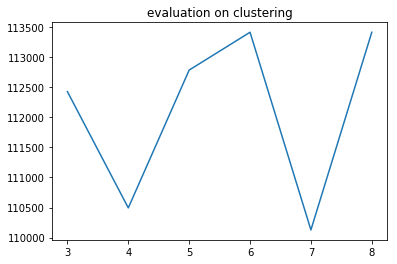

In [79]:
cluster_range = list(range(3,9))
plt.figure()
plt.title('evaluation on clustering')
plt.plot(cluster_range, errors)
plt.show()